In [1]:
%matplotlib inline

# Object detection in the street

This file is the main notebook (temporary just a structure now of all steps that we can do) for our DL4CV project. Our aim is to detect the object in the street by means of a convolutional neural network. The detection will be like a segmentation task with find out what each pixel of the object in a photo belongs to.

The Python version:

In [2]:
import sys
sys.version

'3.6.3 |Anaconda, Inc.| (default, Oct 13 2017, 12:02:49) \n[GCC 7.2.0]'

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.autograd import Variable
import torch.nn as nn
import pandas as pd
import numpy as np
import math
import random
import os
from PIL import Image
from torch.utils.data import Dataset, sampler
from MyFolder import MyImageFolder
from visualisation import label_img_to_rgb
import matplotlib.pyplot as plt

## Feature engineering

### This step should be to load the data images and the label images (by pixel), while doing feature engineering


--In leftImg8bit.zip, the train and test images are all 8-bit 2048*1024 pixels png type images. 

--In gtCoarse, the train and test labels are all 2048*1024 pixels png type images, which ONLY color the road in pink and the small objects on it in blue, the other pixels are black.

-- ...

In [4]:
labelscsv = pd.read_csv("labels.csv")

In [5]:
print(labelscsv.shape)
#print(labelscsv)

(35, 10)


### The pre-training of the images contains the following steps:

--Using transform.Scale to rize the images into width = 256 (To be modified)

--take the center part with 224 x 224 (We know that the resnet requires an input of 224 x 224)

--transforms each pixel from [0,255] to [0,1] 
--> Are we sure we want to do this? Won't we lose resolution? 

--Normalisation for resnet

In [6]:
transform = transforms.Compose(
#    [transforms.Scale(256),
#     [transforms.CenterCrop(224),     
     [transforms.ToTensor()])
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

targettransform = transforms.Compose(
#    [transforms.Scale(256),
#     [transforms.CenterCrop(224),  
     [transforms.ToTensor(),
     transforms.Normalize((0, 0, 0), (1/255, 1/255, 1/255))])
root = '../'
li8b = 'leftImg8bit_trainvaltest_samples/leftImg8bit/'
gt = 'gtFine_trainvaltest_samples/gtFine/'
datatrain = MyImageFolder(root1=root+li8b+'train', root2=root+gt+'train' , transform = transform , target_transform= targettransform)
dataval = MyImageFolder(root1=root+li8b+'val', root2=root+gt+'val' , transform = transform , target_transform= targettransform)
datatest = MyImageFolder(root1=root+li8b+'test', root2=root+gt+'test' , transform = transform , target_transform= targettransform)


### An example of the data after feature-engineering

Train size:  146
Validation size:  23
test size:  42
Img size:  torch.Size([3, 1024, 2048])
Segmentation size:  torch.Size([1024, 2048])


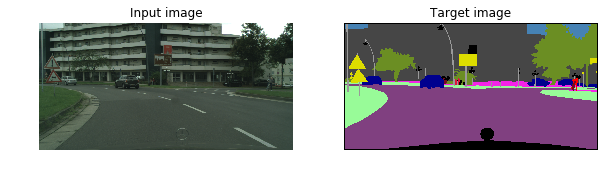

In [7]:
x,y=datatrain[0]
print("Train size: ", len(datatrain))
print("Validation size: ", len(dataval))
print("test size: ", len(datatest))
print("Img size: ", x.size())
print("Segmentation size: ", y.size())

plt.figure(figsize=(10, 15))
# img
plt.subplot(3, 2, 1)
plt.imshow(x.numpy().transpose(1,2,0))
plt.axis('off')
plt.title("Input image")
    
    # target
plt.subplot(3, 2, 2)
plt.imshow(label_img_to_rgb(y.numpy()))
plt.axis('off')
plt.title("Target image")
plt.show()

## Now we construct our net

In [8]:
from Mynet34 import PretrainedResNet34, MyNet
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

The hyper-parameters

In [9]:
num_classes = labelscsv.shape[0]-1
nbtrain=len(datatrain)
nbval=len(dataval)
nbtest=len(datatest)

weightpath = "dlcv_weight34.pth"
# where the weights are saved in the end, for further reuse

batchsize = 1
useGPU = torch.cuda.is_available()

We take a pretrained Resnet

In [10]:
pretrained_net = PretrainedResNet34()
pretrained_net.load_state_dict(models.resnet34(pretrained=True).state_dict())
net = MyNet(num_classes, pretrained_net)
if useGPU:
    net.cuda()

In [11]:
criterion = torch.nn.CrossEntropyLoss(ignore_index=-1)
if useGPU:
    criterion.cuda()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

trainloader = DataLoader(datatrain, batch_size=batchsize, sampler=sampler.RandomSampler(datatrain))
valloader = DataLoader(dataval, batch_size=batchsize)
testloader = DataLoader(datatest, batch_size=batchsize)

We take a pretrained model if it exists.

In [12]:
import os.path
if os.path.exists(weightpath):
    net.load_state_dict(torch.load(weightpath))
    print("Loaded weights at:"+weightpath)
else:
    print("No pretrained weights found at:"+weightpath)

No pretrained weights found at:dlcv_weight34.pth


## Train the net

In [ ]:
print("Start training")

needNewEpoch= True
lastTrainLoss=10
lastValLoss=10
epoch=0

#for epoch in range(10):  # loop over the dataset multiple times
while needNewEpoch:       
    #--------------------------------------training period---------------------------------------
    running_loss = 0.0
    epochloss = 0.0
    numsample=0
    printfrequence=20
    
    net.train()
    for inputs, labels in trainloader:
        if useGPU:
            inputs = inputs.cuda()
            labels = labels.cuda()
        inputs, labels = Variable(inputs), Variable(labels)
   
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.data[0]
        epochloss+=loss.data[0]
        numsample += batchsize
        if numsample % printfrequence == 0: #printfrequence-1: 
            print('[%d, %5d] loss: %.5f' % (epoch+1, numsample, running_loss / printfrequence))
            running_loss = 0.0
    newTrainLoss = epochloss/nbtrain        
    print('The average loss of epoch ', epoch+1, ' is ', newTrainLoss)
    torch.save(net.state_dict(),weightpath)
    #--------------------------------------validation period---------------------------------------
    meanCorrectProba = 0.0
    epochloss = 0.0
    numsample=0
    printfrequence=20
    
    net.eval()
    for inputs, labels in valloader:
        if useGPU:
            inputs = inputs.cuda()
            labels = labels.cuda()
        inputs, labels = Variable(inputs), Variable(labels)
        outputs=net(inputs)
        loss = criterion(outputs, labels)
        meanProbability=np.exp(-loss.data[0])
        
        # print statistics
        epochloss += loss.data[0]
        meanCorrectProba += meanProbability
        numsample += batchsize
        #if numsample % printfrequence == 0: #printfrequence-1: 
        #    print(numsample, ' validation images passed')
    newValLoss = epochloss / nbval
    print('The average validation loss is ', newValLoss)
    print('The average correctness of the validation data is ', meanCorrectProba/nbval*100, '%')
    #--------------------------------------judgment the necessity of a new epoch---------------------------------------
    if (lastValLoss-newValLoss<0.01) and (lastTrainLoss-newTrainLoss<0.01):
        needNewEpoch=False
    else:
        lastLoss=newValLoss 
        epoch=epoch+1

print("End training")

Start training
[1,    20] loss: 2.13497
[1,    40] loss: 0.90793
[1,    60] loss: 1.00828
[1,    80] loss: 0.85742
[1,   100] loss: 0.83882
[1,   120] loss: 1.02509
[1,   140] loss: 1.18006
The average loss of epoch  1  is  1.1228408752238914
The average validation loss is  1.00332582515219
The average correctness of the validation data is  38.2442851993 %
[2,    20] loss: 1.02748
[2,    40] loss: 1.05073
[2,    60] loss: 0.96452
[2,    80] loss: 0.61464
[2,   100] loss: 0.71539
[2,   120] loss: 0.71989
[2,   140] loss: 0.69124
The average loss of epoch  2  is  0.8115371796366286
The average validation loss is  0.5828594889329828
The average correctness of the validation data is  57.3799971122 %
[3,    20] loss: 0.60435
[3,    40] loss: 0.57740
[3,    60] loss: 0.43384
[3,    80] loss: 0.48108
[3,   100] loss: 0.51381
[3,   120] loss: 0.52568
[3,   140] loss: 0.42884
The average loss of epoch  3  is  0.5081078068238415
The average validation loss is  0.4754180629616198
The average corr

In [13]:
meanCorrectProba = 0.0
numsample=0
printfrequence=20
    
net.eval()
for inputs, labels in trainloader:
    if useGPU:
        inputs = inputs.cuda()
        labels = labels.cuda()
    inputs, labels = Variable(inputs), Variable(labels)
    outputs=net(inputs)
    loss = criterion(outputs, labels)
    meanProbability=np.exp(-loss.data[0])
        
    # print statistics
    meanCorrectProba += meanProbability
    numsample += batchsize
#    if numsample % printfrequence == 0: #printfrequence-1: 
#        print('[%d, %5d] loss: %.5f' % (epoch+1, numsample, running_loss / printfrequence))
#        running_loss = 0.0
print('The average correctness of the validation data is ', meanCorrectProba/nbval*100, '%')

The average correctness of the test data is  66.1650939713 %


 ## Visualization

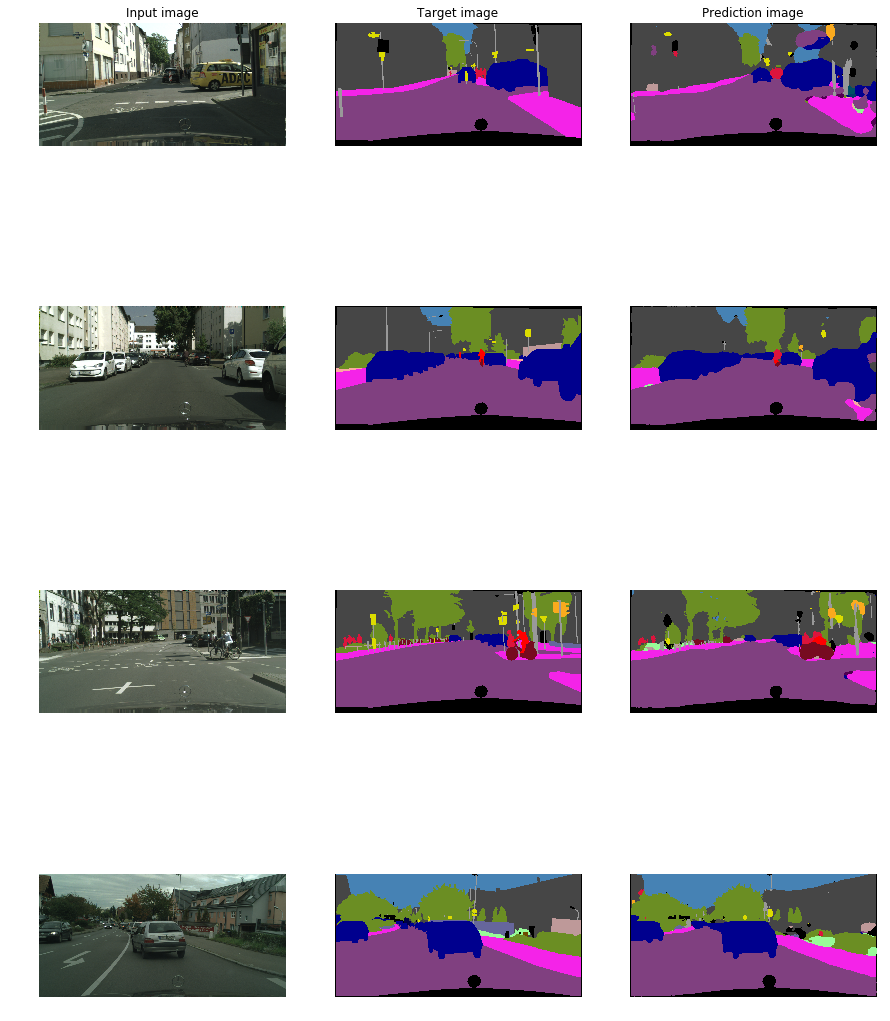

In [13]:
num_example_imgs = 4
plt.figure(figsize=(15, 5 * num_example_imgs))
for i in range (num_example_imgs):
    x,y=dataval[i]
    inputs = x.unsqueeze(0)
    inputs = Variable(inputs)
    if useGPU:
        inputs = inputs.cuda()
    
    outputs = net(inputs)
    _, preds = torch.max(outputs, 1)
    pred = preds[0].data.cpu()
    
    img, target, pred = x.numpy(), y.numpy(), pred.numpy()
    
    # img
    plt.subplot(num_example_imgs, 3, i * 3 + 1)
    plt.axis('off')
    plt.imshow(img.transpose(1,2,0))
    if i == 0:
        plt.title("Input image")
    
    # target
    plt.subplot(num_example_imgs, 3, i * 3 + 2)
    plt.axis('off')
    plt.imshow(label_img_to_rgb(target))
    if i == 0:
        plt.title("Target image")

    # pred
    plt.subplot(num_example_imgs, 3, i * 3 + 3)
    plt.axis('off')
    plt.imshow(label_img_to_rgb(pred))
    if i == 0:
        plt.title("Prediction image")
    
plt.show()

In [ ]:
print("Start training")
newseuil=torch.Tensor(numlabels)

ConfusionMatrixTrain=[torch.Tensor() for i in range(numlabels)]
ConfusionMatrixValidation=[torch.Tensor() for i in range(numlabels)]
ConfusionMatrixTest=[torch.Tensor() for i in range(numlabels)]
APM=Meter.APMeter()

for epoch in range(2):  # loop over the dataset multiple times
       
    #--------------------------------------training period---------------------------------------
    running_loss = 0.0
    epochloss = 0.0
    numsample=0
    printfrequence=10000
    for i in range(numlabels):
        ConfusionMatrixTrain[i]=torch.IntTensor(2,2).zero_()
    
    net.train()
    for inputs, labels in trainloader:
        if useGPU:
            inputs = inputs.cuda()
            labels = labels.cuda()
        inputs, labels = Variable(inputs), Variable(labels)
   
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #trainging confusion matrix
        result=FinalResult(outputs.data.cpu(), seuil.repeat(outputs.data.cpu().size(0),1))
        for j in range(labels.data.cpu().size(0)):
            for i in range(numlabels):
                ConfusionMatrixTrain[i][int(labels.data.cpu()[j][i])][int(result.cpu()[j][i])]+=1

        # print statistics
        running_loss += loss.data[0]
        epochloss+=loss.data[0]
        numsample += batchsize
        if numsample % printfrequence == 0: #printfrequence-1:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.5f' % (epoch+1, numsample, running_loss / printfrequence))
            running_loss = 0.0
    print('The average loss of epoch ', epoch+1, ' is ', epochloss/nbtrain)
    print('The confusion matrixs for training are: ', ConfusionMatrixTrain)
    traingraph.append(epochloss/nbtrain)
    ConMatTrain.append(ConfusionMatrixTrain.copy())
    torch.save(net.state_dict(),weightpath)
    
    #--------------------------------------Validation period---------------------------------------
    
    running_loss = 0.0
    epochloss = 0.0
    numsample=0
    printfrequence=10000
    for i in range(numlabels):
        newseuil[i]=0.0
        ConfusionMatrixValidation[i]=torch.IntTensor(2,2).zero_()
    
    net.eval()
    for inputs, labels in validationloader:
        if useGPU:
            inputs = inputs.cuda()
        outputs=net(Variable(inputs))
        result=FinalResult(outputs.data.cpu(), seuil.repeat(outputs.data.cpu().size(0),1))
        
        #validation confusion matrix
        for j in range(labels.cpu().size(0)):
            newseuil+=outputs.data.cpu()[j]
            numsample+=1
            for i in range(numlabels):
                ConfusionMatrixValidation[i][int(labels.cpu()[j][i])][int(result.cpu()[j][i])]+=1

  
    newseuil=newseuil/numsample
    seuil=newseuil.clone()
    print('The seuil of epoch', epoch+1, ' is defined at', seuil)
    ConMatValidation.append(ConfusionMatrixValidation.copy())
    #print('The confusion matrixs for validation are: ', ConfusionMatrixvalidation)
    
    #--------------------------------------Test period---------------------------------------
    
    APM.reset()
    numsample=0
    printfrequence=10000
    classerror=torch.zeros(numlabels)
    for i in range(numlabels):
        ConfusionMatrixTest[i]=torch.IntTensor(2,2).zero_()
        
    net.eval()
    for inputs, labels in testloader:
        if useGPU:
            inputs = inputs.cuda()
            
        outputs=net(Variable(inputs))
        result=FinalResult(outputs.data.cpu(), seuil.repeat(outputs.data.cpu().size(0),1))
        
        for j in range(labels.size(0)):
            classerror.add_(torch.Tensor.float((labels[j]-result.cpu()[j]).abs()))
            numsample +=1
            APM.add(outputs.data.cpu()[j], labels[j])
            for i in range(numlabels):
                ConfusionMatrixTest[i][int(labels[j][i])][int(result.cpu()[j][i])]+=1
        
        if numsample % printfrequence == 0: #printfrequence-1:    # print every 100 mini-batches
            print(numsample, 'images passed')

    
    print('In total we have ', numsample, 'images for the test.')
    print("The Average Precision are ", APM.value())
    #print("The correctness per class are ", torch.ones(numlabels).sub(classerror.div_(numsample)))
    print("The mean test loss is ", classerror.div_(numsample).mean())
    print('The confusion matrixs for test are: ', ConfusionMatrixTest)
    ConMatTest.append(ConfusionMatrixTest.copy())
    testgraph.append(classerror.mean())

In [ ]:
import matplotlib.pyplot as plt
#plt.plot([1,2,3,4])
plt.axis([0, 10, 0, 0.5])

plt.plot(traingraph, label="training loss")
plt.plot(testgraph, label="test loss")
legend = plt.legend()

plt.ylabel('mean loss')
plt.show()

Analysis the result

In [ ]:
import matplotlib.pyplot as plt
#plt.plot([1,2,3,4])
plt.axis([0, 10, 0.75, 1])

plt.plot(x1, label="train lisse-dente")
plt.plot(x2, label="train alterne-oppose")
plt.plot(x3, label="train simple-composee")
plt.plot(x4, label="train non ligneux-ligneux")

plt.plot(y1, label="test lisse-dente")
plt.plot(y2, label="test alterne-oppose")
plt.plot(y3, label="test simple-composee")
plt.plot(y4, label="test non ligneux-ligneux")

legend = plt.legend()

plt.xlabel('epoch')
plt.ylabel('Correctness par class')
plt.show()